https://dataplay.tistory.com/27

# - ResNet(ResNet50)

https://eremo2002.tistory.com/76

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [2]:
img_dir = 'data/Images3'
categories = os.listdir(img_dir)
num_classes = len(categories)

In [3]:
image_w = 224
image_h = 224

In [4]:
X = []
y = []

for index, breed in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[index] = 1

    image_dir = img_dir + "/" + breed
    files = glob.glob(image_dir+"/*.jpg")
    print(index, ")", breed, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

0 ) n02085620-Chihuahua  파일 길이 :  152
1 ) n02085782-Japanese_spaniel  파일 길이 :  185
2 ) n02085936-Maltese_dog  파일 길이 :  252
3 ) n02086079-Pekinese  파일 길이 :  149
4 ) n02086240-Shih-Tzu  파일 길이 :  214
5 ) n02086646-Blenheim_spaniel  파일 길이 :  188
6 ) n02086910-papillon  파일 길이 :  196
7 ) n02088364-beagle  파일 길이 :  195
8 ) n02088466-bloodhound  파일 길이 :  187
9 ) n02089078-black-and-tan_coonhound  파일 길이 :  159
10 ) n02089867-Walker_hound  파일 길이 :  153
11 ) n02089973-English_foxhound  파일 길이 :  157
12 ) n02091032-Italian_greyhound  파일 길이 :  182
13 ) n02091134-whippet  파일 길이 :  187
14 ) n02093256-Staffordshire_bullterrier  파일 길이 :  155
15 ) n02093647-Bedlington_terrier  파일 길이 :  182
16 ) n02094258-Norwich_terrier  파일 길이 :  185
17 ) n02094433-Yorkshire_terrier  파일 길이 :  164
18 ) n02096294-Australian_terrier  파일 길이 :  196
19 ) n02096585-Boston_bull  파일 길이 :  182
20 ) n02097047-miniature_schnauzer  파일 길이 :  154
21 ) n02097209-standard_schnauzer  파일 길이 :  155
22 ) n02097658-silky_terrier  파일 길이 :  183

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
n = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(n)

In [7]:
X = X[n]
y = y[n]

In [8]:
print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",y.shape)

Images shape after shuffling =  (11411, 224, 224, 3) 
Labels shape after shuffling =  (11411, 65)


In [9]:
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [11]:
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (8215, 224, 224, 3)
y_train shape =  (8215, 65)

x_val shape =  (913, 224, 224, 3)
y_val shape =  (913, 65)

x_test shape =  (2283, 224, 224, 3)
y_test shape =  (2283, 65)


In [12]:
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(32, (5, 5), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    return x   

In [13]:
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)
    shortcut = x
 
    for i in range(2):
        if (i == 0):
            x = Conv2D(32, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(32, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

In [14]:
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(2):     
        if(i == 0):            
            x = Conv2D(64, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x

In [15]:
def conv4_layer(x):
    shortcut = x        
  
    for i in range(2):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

In [16]:
input_tensor = Input(shape=(image_w, image_h, 3), name='input')
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(num_classes, activation='softmax')(x)
 
model = Model(input_tensor, output_tensor)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 2432        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 128         conv2d[0][0]                     
_______________________________________________________________________________________

In [17]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0001)

In [18]:
early_stopping= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 10)
model_checkPoint = ModelCheckpoint('ResNet.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [19]:
history =model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), shuffle=True, batch_size=128, callbacks=[early_stopping, model_checkPoint])

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 4.2030 - accuracy: 0.0435
Epoch 00001: val_loss improved from inf to 4.18660, saving model to ResNet.h5
65/65 [==============================] - 496s 8s/step - loss: 4.2030 - accuracy: 0.0435 - val_loss: 4.1866 - val_accuracy: 0.0252
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 3.8819 - accuracy: 0.0753
Epoch 00002: val_loss did not improve from 4.18660
65/65 [==============================] - 481s 7s/step - loss: 3.8819 - accuracy: 0.0753 - val_loss: 4.2939 - val_accuracy: 0.0153
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 3.7653 - accuracy: 0.0949
Epoch 00003: val_loss did not improve from 4.18660
65/65 [==============================] - 476s 7s/step - loss: 3.7653 - accuracy: 0.0949 - val_loss: 4.7686 - val_accuracy: 0.0186
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 3.6705 - accuracy: 0.1145
Epoch 00004: val_loss did not improve from 4.18660

Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 2.1633 - accuracy: 0.4790
Epoch 00030: val_loss did not improve from 3.09673
65/65 [==============================] - 488s 8s/step - loss: 2.1633 - accuracy: 0.4790 - val_loss: 3.2543 - val_accuracy: 0.1972
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 2.1219 - accuracy: 0.4817
Epoch 00031: val_loss did not improve from 3.09673
65/65 [==============================] - 486s 7s/step - loss: 2.1219 - accuracy: 0.4817 - val_loss: 3.1839 - val_accuracy: 0.2026
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 2.0735 - accuracy: 0.5089
Epoch 00032: val_loss did not improve from 3.09673
65/65 [==============================] - 483s 7s/step - loss: 2.0735 - accuracy: 0.5089 - val_loss: 3.4336 - val_accuracy: 0.1676
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 2.0248 - accuracy: 0.5195
Epoch 00033: val_loss did not improve from 3.09673
65/65 [===============

In [20]:
loss, accuracy = model.evaluate(x_test, y_test)

print('\nLoss: {:.4f}, Acc: {:.4f}'.format(loss, accuracy))

72/72 [==============================] - 25s 347ms/step - loss: 3.2769 - accuracy: 0.1827

Loss: 3.2769, Acc: 0.1827


In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

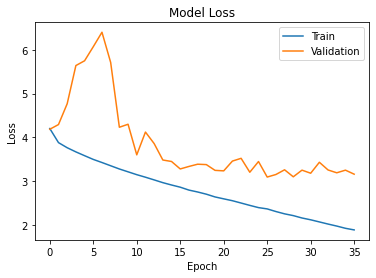

In [22]:
plot_loss(history)
plt.show()

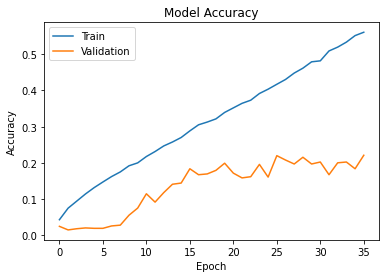

In [23]:
plot_acc(history)
plt.show()

In [24]:
predictions = model.predict(x_test)

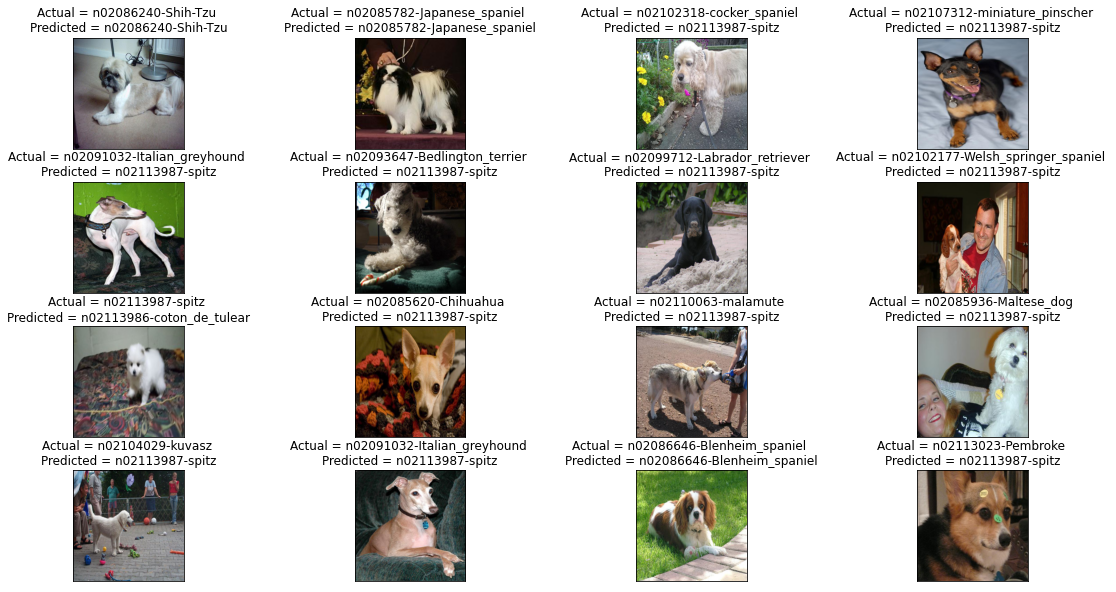

In [26]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(16):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(4, 4, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {} \nPredicted = {}'.format(categories[np.argpartition(y_test[r[0]],-1)[-1:][0]] , categories[np.argpartition(predictions[r[0]][y_test[r[0]]],-1)[-1:][0]]))
    plt.xticks([]) , plt.yticks([])

plt.show()